In [55]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS

import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns



In [56]:
symbol_list=['META','AMZN','AAPL','NFLX','GOOG']
data=yf.download(symbol_list,start='2014-01-01',end='2015-01-01')['Adj Close']

[*********************100%***********************]  5 of 5 completed


In [29]:
def find_cointegrated_pairs(data):
    cointegration_matrix=np.zeros((5,5))
    coint_stocks=[]
    for i in range(5): 
        for j in range(5): 
            if i!=j:
                stock1=symbol_list[i]
                stock2=symbol_list[j]
                cointegration_matrix[i,j]=coint(data[stock1],data[stock2])[1] 
            else:
                cointegration_matrix[i,j]= 1
        for i in range(5): 
            for j in range(5): 
                if cointegration_matrix[i,j] < 0.05:
                    coint_stocks=(symbol_list[i],symbol_list[j])
    return coint_stocks, cointegration_matrix


In [30]:
coint_stocks, cointegration_matrix= find_cointegrated_pairs(data)

In [47]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1,n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [49]:
score_matrix, pvalue_matrix, pairs=find_cointegrated_pairs(data)

In [50]:
pvalue_matrix

array([[1.        , 0.73743884, 0.79498748, 0.66564924, 0.97419968],
       [1.        , 1.        , 0.03286166, 0.15251473, 0.17955584],
       [1.        , 1.        , 1.        , 0.51767126, 0.08824352],
       [1.        , 1.        , 1.        , 1.        , 0.76582795],
       [1.        , 1.        , 1.        , 1.        , 1.        ]])

<Axes: >

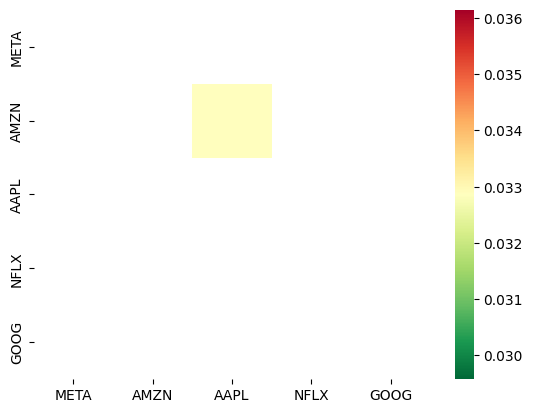

In [51]:
sns.heatmap(
    pvalue_matrix, 
    xticklabels=symbol_list, 
    yticklabels=symbol_list, 
    cmap='RdYlGn_r', 
    mask = ( pvalue_matrix >= 0.05)
)

In [53]:
pairs

[('AMZN', 'GOOG')]

Model the Spread: 
Now that we found a pair, we run a linear regression using statsmodels and model the spread as a linear combination of AAPL and AMZN. b is the beta coefficient from the linear regression, otherwise known as the “hedge ratio.”

In [65]:
S1= data.AMZN
S2=data.AAPL

S1=sm.add_constant(S1)
results=sm.OLS(S1,S2).fit()

S1=S1.AMZN

b=results.params['AMZN']
spread=S2-b*S1

spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread'])

"S1=S1.AMZN\n\nb=results.params['AMZN']\nspread=S2-b*S1\n\nspread.plot()\nplt.axhline(spread.mean(), color='black')\nplt.legend(['Spread'])"

In [66]:
S1

,const,AMZN
Date,,
2014-01-02,1.0,19.898500
2014-01-03,1.0,19.822001
2014-01-06,1.0,19.681499
2014-01-07,1.0,19.901501
2014-01-08,1.0,20.096001
...,...,...
2014-12-24,1.0,15.151500
2014-12-26,1.0,15.454500
2014-12-29,1.0,15.602000


In [60]:
results.params

,0,1
AAPL,0.047624,0.786417
